# Introduction


This notebook is focused on charting bio-optics data from the Ocean Observatores Initiative. 
The contents (specifically data charts) should display in **binder**. However the data may be 
stored external to the **ocean** repository; in which case the code that reads datafiles will
not run properly.


> ***Recommendation: The casual reader is encouraged to skim down to charts and captions.***


<BR>
<img src="./Images/rca/shallow%20profiler%20platform%201%20in%20situ.png" style="float: left;" alt="drawing" width="400"/>
<div style="clear: left"><BR>


In [3]:
import os, sys, time, glob, warnings
from IPython.display import clear_output             # use inside loop with clear_output(wait = True) followed by print(i)
warnings.filterwarnings('ignore')
this_dir = os.getcwd()
data_dir = this_dir + '/../data'                  # large datasets reside outside the repository

from matplotlib import pyplot as plt
from matplotlib import colors as mplcolors
import numpy as np, pandas as pd, xarray as xr
from numpy import datetime64 as dt64, timedelta64 as td64

# convenience functions abbreviating 'datetime64' and so on
def doy(theDatetime): return 1 + int((theDatetime - dt64(str(theDatetime)[0:4] + '-01-01')) / td64(1, 'D'))
def dt64_from_doy(year, doy): return dt64(str(year) + '-01-01') + td64(doy-1, 'D')
def day_of_month_to_string(d): return str(d) if d > 9 else '0' + str(d)

print('\nJupyter Notebook running Python {}'.format(sys.version_info[0]))


Jupyter Notebook running Python 3


In [4]:
# Shallow profiler metadata (timestamps for Ascent / Descent / Rest are stored in a set of files in
#   the Profiles subdirectory. These are read into a Pandas Dataframe in the function given below.
#
# Specific to the profile files: We have CSV files with columns corresponding to ascent start, etcetera.
# This function reads and assorts these time stamps. It keeps them in chronological order but there is
#   at the moment no further metadata; for example concerning time of day.

def ReadProfileMetadata(fnm):
    """
    Profiles are saved by site and year as 12-tuples. Here we read only
    the datetimes (not the indices) so there are only six values. These
    are converted to Timestamps. They correspond to ascend start/end, 
    descend start/end and rest start/end. Timestamps are a bit easier to
    use than datetime64 values, being essentially wrappers around the latter with
    additional utility.
    """
    pDf = pd.read_csv(fnm, usecols=["1", "3", "5", "7", "9", "11"])
    pDf.columns=['ascent_start', 'ascent_end', 'descent_start', 'descent_end', 'rest_start', 'rest_end']
    pDf['ascent_start']  = pd.to_datetime(pDf['ascent_start'])
    pDf['ascent_end']    = pd.to_datetime(pDf['ascent_end'])
    pDf['descent_start'] = pd.to_datetime(pDf['descent_start'])
    pDf['descent_end']   = pd.to_datetime(pDf['descent_end'])
    pDf['rest_start']    = pd.to_datetime(pDf['rest_start'])
    pDf['rest_end']      = pd.to_datetime(pDf['rest_end'])
    return pDf


def GenerateTimeWindowIndices(pDf, date0, date1, time0, time1):
    '''
    Given two day boundaries and a time window (UTC) within a day: Return a list
    of indices of profiles that start within both the day and time bounds. This 
    works from the passed dataframe of profile times.
    '''
    nprofiles = len(pDf)
    pIndices = []
    for i in range(nprofiles):
        a0 = pDf["ascent_start"][i]
        if a0 >= date0 and a0 <= date1 + td64(1, 'D'):
            delta_t = a0 - dt64(a0.date())
            if delta_t >= time0 and delta_t <= time1: pIndices.append(i)
    return pIndices


def ProfileEvaluation(t0, t1, pDf):
    '''
    At this time the profile metadata in pDf is broken up by year of interest and site.
    For example the code above concerns Oregon Slope Base (OSB) and the year 2021. 
    Only profiles through June are available.
    
    This function evaluates profiles within a given time range: How many profiles are there?
    How many 'local noon', how many 'local midnight'? This is a simple way to check profiler 
    operating consistency. This depends in turn on the profiler metadata reliability.
    '''
    global midn0, midn1, noon0, noon1
    
    nTotal = 0
    nMidn = 0
    nNoon = 0
    nNinePerDay = 0

    for i in range(len(pDf)):
            
        if pDf["ascent_start"][i] >= t0 and pDf["ascent_start"][i] <= t1:
            nTotal += 1
            
            if pDf["descent_end"][i] - pDf["descent_start"][i] >= td64(60, 'm'):
                
                tProf = pDf["ascent_start"][i]
                day_time = tProf - dt64(tProf.date())

                if   day_time > midn0 and day_time < midn1: nMidn += 1
                elif day_time > noon0 and day_time < noon1: nNoon += 1
                else: print("found a long descent that did not fit noon or midnight...")
        
    return nTotal, nMidn, nNoon

In [5]:
# Note these are profile times for Axial Base
pDf21 = ReadProfileMetadata(os.getcwd()+"/./Profiles/osb2021.csv")

# time ranges for midnight and noon profiles, adjusted for UTC
midn0 = td64( 7*60 + 10, 'm')        # 7 hours 10 minutes
midn1 = td64( 7*60 + 34, 'm')        # 7 hours 34 minutes
noon0 = td64(20*60 + 30, 'm')        # 20 hours 30 minutes
noon1 = td64(20*60 + 54, 'm')        # 20 hours 54 minutes 

# Some code to test out the above ProfileEvaluation() function
t0, t1 = dt64('2021-01-01'), dt64('2021-02-01')
nDays = (t1 - t0).astype(int)
nTotal, nMidn, nNoon = ProfileEvaluation(t0, t1, pDf21)

print("For 2021, month of January, we have...")
print(nDays, 'days or', nDays*9, 'possible profiles')
print("There were, over this time, in fact...")
print(nTotal, 'profiles;', nMidn, 'at local midnight and', nNoon, 'at local noon')

For 2021, month of January, we have...
31 days or 279 possible profiles
There were, over this time, in fact...
256 profiles; 28 at local midnight and 29 at local noon


In [15]:
# global sensor range parameters for charting data: based on osb shallow profiler data

# axis ranges for a variety of sensors
par_lo,         par_hi           =   -10.0,      300.
nitrate_lo,     nitrate_hi       =     0.,        35.
do_lo,          do_hi            =    50.0,      300.
chlora_lo,      chlora_hi        =    -0.1,        1.2
temp_lo,        temp_hi          =     6.5,       11.
salinity_lo,    salinity_hi      =    32.0,       35.
backscatter_lo, backscatter_hi   =     0.0007,     0.0020
cdom_lo,        cdom_hi          =     0.6,        1.4
si412_lo,       si412_hi         =     0.0,       80.0
si443_lo,       si443_hi         =     0.0,       80.0
si490_lo,       si490_hi         =     0.0,       80.0
si510_lo,       si510_hi         =     0.0,       80.0
si555_lo,       si555_hi         =     0.0,       80.0
si620_lo,       si620_hi         =     0.0,       15.0
si683_lo,       si683_hi         =     0.0,        6.0
veast_lo,       veast_hi         =    -0.4,        0.4
vnorth_lo,      vnorth_hi        =    -0.4,        0.4
vup_lo,         vup_hi           =    -0.4,        0.4

# ax.plot(dsI.time, dsI.si683,

In [16]:
# Concerning the names of data variables
# Some engineering elements of OOI result in complex names. This commented-out code fragment demonstrates
#   opening a NetCDF file as an XArray Dataset and renaming a data variable to something simpler.
#
# dsO = xr.open_dataset(data_dir + "/data_explorer_1Min/axb/profiler/axb_profiler_doxygen_1Min.nc")
# dsO = dsO.rename_vars({"moles_of_oxygen_per_unit_mass_in_sea_water_profiler_depth_enabled":"doxygen"})
# dsO

In [59]:
# This cell formerly loaded selected datasets from the large (multi-year) data pool. This pool is 
#   external to the repository owing its large volume. This read cell is therefore now deprecated
#   in favor of subsequent cells that load smaller datasets from within the repository.
#
# To keep code compact I use the following table of abbreviations for sensors.
#   BioOptics includes Fluorometers, the main emphasis here. Fluorometers carry either two or
#   three sensor types: Chlorophyll-A, Color Dissolved Organic Matter (CDOM), and particulate backscatter. 
#   The BioOptics ensemble also includes PAR and Spectral Irradiance. PAR measurements are individual
#   values. Spectral irradiance is seven values per observation. Spectrophotometers are not considered
#   in this notebook.
#
# Dictionary of single-letter sensor keys: The capitalized letter follows 'ds', an abbreviation for
#   an XArray Dataset. We have therefore: dsA, dsB, dsC, etcetera
#
# Desig     Data                     Renamed                 Instrument
# -----     ----                     -------                 ----------
# A         Chlorophyll-A            chlora                  fluorometer
# B         backscatter              backscatter             fluorometer
# C         CDOM                     cdom                    fluorometer
# G         pCO2                     pco2                    ?
# H         pH                       ph                      pH
# I         Spectral Irradiance      ?                       spkir
# M         Reserved for Nitrate'    ?                       nitrate
# N         Nitrate                  ?                       nitrate
# P         PAR                      par                     PAR
# Q         pressure                 pressure                CTD
# O         dissolved oxygen         doxygen                 CTD
# S         salinity                 salinity                CTD
# T         temperature              temp                    CTD
# U         velocity east            veast                   ADCP
# V         velocity north           vnorth                  ADCP
# W         velocity up              vup                     ADCP
#
# 
# Shallow profilers begin at rest at a depth of 200 meters. They ascend to within
#   about 10 meters of the surface, then descend to create a double profile dataset;
#   whereupon they return to the at-rest state. This cycle repeats nine times per
#   day. What follows is a simple dictionary of interval designators: The capital letter 
#   follows the sensor key
#
# A     Ascent
# D     Descent
# R     Rest
#
#
# There are three RCA shallow profiler sites with names abbreviated herein:
#
# osb           Oregon Slope Base
# axb           Axial Base
# oos           Oregon Offshore (part of the Endurance array)
#
# For more on this see the README.md file and the Notebooks subdirectory.

####################
####################
####
#### IMPORTANT!!!!!!!!!!!
####
####    The code below loads data and ***renames*** the data variables to make them easier to work with
####
####################
####################

# These data files for Oregon Slope Base were pulled from the OOI "data explorer" and stored 
#   in the data directory outside this repository. The data are timestamped at one minute intervals.

# data_source = data_dir + '/data_explorer_1Min/'

# dsA = xr.open_dataset(data_source + 'osb/profiler/osb_profiler_chlora_1Min.nc')
# dsB = xr.open_dataset(data_source + 'osb/profiler/osb_profiler_backscatter_1Min.nc')
# dsC = xr.open_dataset(data_source + 'osb/profiler/osb_profiler_cdom_1Min.nc')
# dsO = xr.open_dataset(data_source + 'osb/profiler/osb_profiler_doxygen_1Min.nc')
# dsS = xr.open_dataset(data_source + 'osb/profiler/osb_profiler_salinity_1Min.nc')
# dsT = xr.open_dataset(data_source + 'osb/profiler/osb_profiler_temperature_1Min.nc')

# dsA = dsA.rename_vars({"mass_concentration_of_chlorophyll_a_in_sea_water_profiler_depth_enabled":"chlora"})
# dsB = dsB.rename_vars({"flubsct_profiler_depth_enabled":"backscatter"})
# dsC = dsC.rename_vars({"cdomflo_profiler_depth_enabled":"cdom"})
# dsO = dsO.rename_vars({"moles_of_oxygen_per_unit_mass_in_sea_water_profiler_depth_enabled":"doxygen"})
# dsS = dsS.rename_vars({"sea_water_practical_salinity_profiler_depth_enabled":"salinity"})
# dsT = dsT.rename_vars({"sea_water_temperature_profiler_depth_enabled":"temp"})

# pCO2: no data
# dsG = xr.open_dataset(data_source + 'osb/profiler/osb_profiler_pco2_1Min.nc')
# dsG = dsG.rename_vars({"partial_pressure_of_carbon_dioxide_in_sea_water_profiler_depth_enabled":"pco2"})

# dsH = xr.open_dataset(data_source + 'osb/profiler/osb_profiler_ph_1Min.nc')
# dsI = xr.open_dataset(data_source + 'osb/profiler/osb_profiler_spkir_1Min.nc')
# dsN = xr.open_dataset(data_source + 'osb/profiler/osb_profiler_nitrate_1Min.nc')
# dsP = xr.open_dataset(data_source + 'osb/profiler/osb_profiler_par_1Min.nc')
# dsU = xr.open_dataset(data_source + 'osb/profiler/osb_profiler_veleast_1Min.nc')
# dsV = xr.open_dataset(data_source + 'osb/profiler/osb_profiler_velnorth_1Min.nc')
# dsW = xr.open_dataset(data_source + 'osb/profiler/osb_profiler_velup_1Min.nc')

# dsH = dsH.rename_vars({"sea_water_ph_reported_on_total_scale_profiler_depth_enabled":"ph"})
# dsI = dsI.rename_vars({"spectir_412nm":"si412",  \
#                        "spectir_443nm":"si443", \
#                        "spectir_490nm":"si490", \
#                        "spectir_510nm":"si510", \
#                        "spectir_555nm":"si555", \
#                        "spectir_620nm":"si620", \
#                        "spectir_683nm":"si683"})
# dsN = dsN.rename_vars({"mole_concentration_of_nitrate_in_sea_water_profiler_depth_enabled":"nitrate"})
# dsP = dsP.rename_vars({"downwelling_photosynthetic_photon_flux_in_sea_water_profiler_depth_enabled":"par"})
# dsU = dsU.rename_vars({"eastward_sea_water_velocity_profiler_depth_enabled":"veast"})
# dsV = dsV.rename_vars({"northward_sea_water_velocity_profiler_depth_enabled":"vnorth"})
# dsW = dsW.rename_vars({"upward_sea_water_velocity_profiler_depth_enabled":"vup"})

In [44]:
# This cell was written to incorporate 1min data in smaller time ranges within the repo
#   Notice that it works with Datasets that are presumed 'already renamed': See cell above.

# month-blocks: All dates use first of the month

# short variable names to fit everything in one line per sensor type

def WriteMonthLongDataBlocks(s, y, z, m, n, u, v, wd):


    dsT.sel(time=slice(u, v)).to_netcdf(wd + 'ctd/'     + s + '_temp_'        + p + y + '_1min.nc')
    dsS.sel(time=slice(u, v)).to_netcdf(wd + 'ctd/'     + s + '_salinity_'    + p + y + '_1min.nc')
    dsO.sel(time=slice(u, v)).to_netcdf(wd + 'ctd/'     + s + '_doxygen_'     + p + y + '_1min.nc')
    dsA.sel(time=slice(u, v)).to_netcdf(wd + 'fluor/'   + s + '_chlora_'      + p + y + '_1min.nc')
    dsB.sel(time=slice(u, v)).to_netcdf(wd + 'fluor/'   + s + '_backscatter_' + p + y + '_1min.nc')
    dsC.sel(time=slice(u, v)).to_netcdf(wd + 'fluor/'   + s + '_cdom_'        + p + y + '_1min.nc')

    dsH.sel(time=slice(u, v)).to_netcdf(wd + 'pH/'      + s + '_ph_'          + p + y + '_1min.nc')
    dsI.sel(time=slice(u, v)).to_netcdf(wd + 'irrad/'   + s + '_spectir_'     + p + y + '_1min.nc')
    dsN.sel(time=slice(u, v)).to_netcdf(wd + 'nitrate/' + s + '_nitrate_'     + p + y + '_1min.nc')
    dsP.sel(time=slice(u, v)).to_netcdf(wd + 'par/'     + s + '_par_'         + p + y + '_1min.nc')
    dsU.sel(time=slice(u, v)).to_netcdf(wd + 'current/' + s + '_veast_'       + p + y + '_1min.nc')
    dsV.sel(time=slice(u, v)).to_netcdf(wd + 'current/' + s + '_vnorth_'      + p + y + '_1min.nc')
    dsW.sel(time=slice(u, v)).to_netcdf(wd + 'current/' + s + '_vup_'         + p + y + '_1min.nc')

    return

s = 'osb'
y, z = '2021', '2021'
m, n = '03', '04'
p = 'march'
u = dt64(y + '-' + m + '-01')
v = dt64(z + '-' + n + '-01')
wd = os.getcwd() + '/RepositoryData/rca/'

# WriteMonthLongDataBlocks(s, y, z, m, n, u, v, wd)


In [60]:
# This cell is the rejoinder to the previous: Now re-load the XArray Datasets from the smaller source files
data_source = os.getcwd() + '/RepositoryData/rca/'

dsA = xr.open_dataset(data_source + 'fluor/osb_chlora_march2021_1min.nc')
dsB = xr.open_dataset(data_source + 'fluor/osb_backscatter_march2021_1min.nc')
dsC = xr.open_dataset(data_source + 'fluor/osb_cdom_march2021_1min.nc')
dsT = xr.open_dataset(data_source + 'ctd/osb_temp_march2021_1min.nc')
dsS = xr.open_dataset(data_source + 'ctd/osb_salinity_march2021_1min.nc')
dsO = xr.open_dataset(data_source + 'ctd/osb_doxygen_march2021_1min.nc')

dsH = xr.open_dataset(data_source + 'pH/osb_ph_march2021_1min.nc')
dsI = xr.open_dataset(data_source + 'irrad/osb_spectir_march2021_1min.nc')
dsN = xr.open_dataset(data_source + 'nitrate/osb_nitrate_march2021_1min.nc')
dsP = xr.open_dataset(data_source + 'par/osb_par_march2021_1min.nc')
dsU = xr.open_dataset(data_source + 'current/osb_veast_march2021_1min.nc')
dsV = xr.open_dataset(data_source + 'current/osb_vnorth_march2021_1min.nc')
dsW = xr.open_dataset(data_source + 'current/osb_vup_march2021_1min.nc')


## Profile duration

This section demonstrates how two of nine daily profiles are extended in duration.

`dt64_from_doy(2021, 60)` converts Day Of Year to datetime64 `numpy.datetime64('2021-03-01')`.

Via trial and error March 1 proves to be 2021 profile number 503 at Oregon Slope Base. The time of
day is UTC, 8 hours ahead of local. Consequently this code


```
for i in [503, 504, 505, 506]:
    print(i, 'profile start / end:', pDf21["ascent_start"][i], pDf21["descent_end"][i], \
          '      duration: ', pDf21["descent_end"][i] - pDf21["ascent_start"][i]) 
```

produces these results: 


```
503 profile start / end: 2021-03-01 00:27:00 2021-03-01 02:05:00       duration:  0 days 01:38:00
504 profile start / end: 2021-03-01 02:42:00 2021-03-01 04:21:00       duration:  0 days 01:39:00
505 profile start / end: 2021-03-01 04:52:00 2021-03-01 06:31:00       duration:  0 days 01:39:00
506 profile start / end: 2021-03-01 07:22:00 2021-03-01 10:03:00       duration:  0 days 02:41:00
```

Profile 506 is an hour longer in duration than the others owing to interval pauses on descent.
This is the midnight-local profile. Profile 578 is midnight-local on March 9. Hence profiles 506
through 577 represent eight days of data, 72 profiles.

The following chart shows depth with time over 24 hours, including the longer descents at midnight and noon.


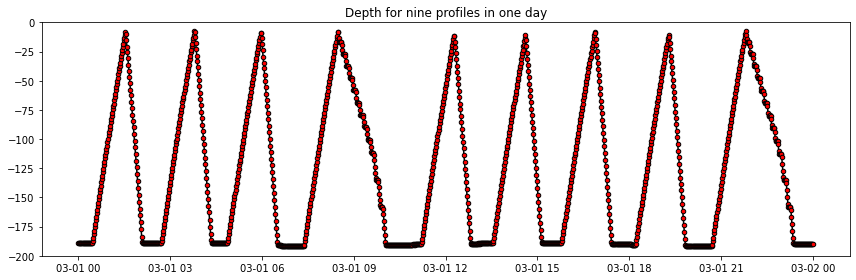

In [47]:
dsT_1d = dsT.sel(time=slice(dt64('2021-03-01'), dt64('2021-03-02')))
fig, axs = plt.subplots(figsize=(12,4), tight_layout=True)
axs.plot(dsT_1d.time, dsT_1d.z, marker='.', ms=9., color='k', mfc='r')
axs.set(ylim = (-200., 0.), title='Depth for nine profiles in one day'); print()

In [48]:
def ChartAB(pDf, xrng, pIdcs, A, Az, Albl, Acolor, B, Bz, Blbl, Bcolor):
    """
    Make a series of charts comparing two types of sensor data, A and B.
    The data are passed in as DataArrays: A and Az are data and z coordinates respectively.
    So A might be dsP.par (PAR DataArray) and depth Az would be dsP.z. Both use time as 
    their dimension. Charting is done over a set of passed profile indices pIdcs[].
    The number of profiles charted is constrained: Too many may bog down the kernel.
    """
    global midn0, midn1, noon0, noon1
        
    # if too many charts are requested: Take the first 117 only
    ncharts = len(pIdcs)
    if ncharts > 117: ncharts = 117
    print("Attempting", ncharts, "charts\n")

    # set up the requested number of charts in a vertical column
    fig, axs = plt.subplots(ncharts, 1, figsize=(12, 4*ncharts), tight_layout=True)

    # create a list of twin axes, one for each chart
    axstwin0 = [axs[i].twiny() for i in range(ncharts)]

    # this index i will range across the dataframe indices for ascent profiles
    for i in range(ncharts):
        
        # Need both a profile index into the profile dataframe pDf and a chart
        #   index 0, 1, 2, ... These are respectively pIdx and i
        pIdx = pIdcs[i]

        ta0, ta1 = pDf["ascent_start"][pIdx], pDf["ascent_end"][pIdx]

        Ax, Ay = A.sel(time=slice(ta0,  ta1)), Az.sel(time=slice(ta0, ta1))
        Bx, By = B.sel(time=slice(ta0,  ta1)), Bz.sel(time=slice(ta0, ta1))
        
        axs[i].plot(Ax, Ay, ms = 4., color=Acolor, mfc=Acolor)
        axstwin0[i].plot(Bx, By, markersize = 4., color=Bcolor, mfc=Bcolor)
        
        # axis ranges
        if i == 0: axs[i].set(title = Albl + ' (' + Acolor + ', lower x-axis) and ' \
                                    + Blbl + ' (' + Bcolor + ', upper x-axis)')

        # Set axis ranges from passed list of pairs xrng[][]
        axs[i].set(     xlim = (xrng[0][0], xrng[0][1]), ylim = (-200., 0.))
        axstwin0[i].set(xlim = (xrng[1][0], xrng[1][1]), ylim = (-200., 0.))

        # chart timestamp (embellish for noon / midnight)
        ascent_start_time = 'Start UTC: ' + str(ta0)
        delta_t = ta0-dt64(ta0.date())
        if delta_t > midn0 and delta_t < midn1: ascent_start_time += " MIDNIGHT local"
        if delta_t > noon0 and delta_t < noon1: ascent_start_time += " NOON local"

        xlabel = xrng[0][0] + (xrng[0][1] - xrng[0][0])/2.
        axs[i].text(xlabel, -10., ascent_start_time)
        
    return fig, axs

Attempting 3 charts



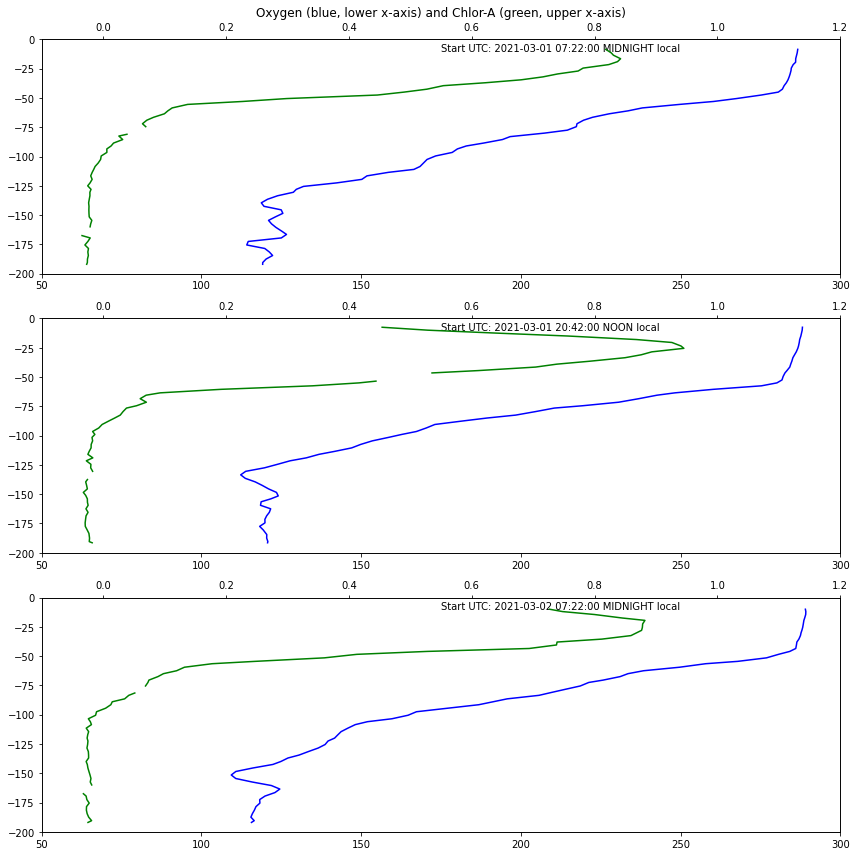

In [49]:
xrng=[(do_lo, do_hi), (chlora_lo, chlora_hi)]                      # dissolved oxygen and chlorophyll-a

# various methods of generating the profile index list
# pIdcs = GenerateTimeWindowIndices(pDf21, dt64_from_doy(2021, 60), dt64_from_doy(2021, 65), noon0, noon1)
# pIdcs = [506, 507, 508, 509, 510, 511, 512, 513, 514]
# pIdcs = [i for i in range(1200,1210)]

# These alternate midnight/noon for ten days starting March 1 2021:
pIdcs = [506, 511, 515] # , 520, 524, 529, 533, 538, 542, 547, 551, 556, 560, 565, 569, 574, 578, 583, 587, 592] 
fig, axs = ChartAB(pDf21, xrng, pIdcs, dsO.doxygen, dsO.z, 'Oxygen', 'blue', dsA.chlora, dsA.z, 'Chlor-A', 'green')

## Comparison of chlorophyll to oxygen

This comparison sequence shows data from shallow profiler ascents. Instruments 
are upward-facing into relatively undisturbed water as the profiler rises. 


The charts above, on casual inspection, show

- Oxygen profiles are fairly consistent and stable over ten days
- Chlorophyll has larger relative variation but trends appear consistent, not noisy
- Chlorophyll features more data dropouts, typically somewhere in the 45 to 85 meter depth range
- Chlorophyll is either flat with depth at the top of the profile or shows a distinct drop-off
- The transition from mixed layer to pycnocline is consistent between oxygen and chlorophyll 

In [50]:
fig.savefig(os.getcwd() + "/Images/charts/Oxygen_Chlorophyll_signals_vs_depth_and_time.png")
print("figure saved to Images/charts")

figure saved to Images/charts


## "One-off" Six Signal Chart


This section combines six signals into one visual: CTD (Temp / Salinity / Dissolved Oxygen) 
plus three Flourometer signals: CDOM, Chlor-A and Backscatter. These are placed into 
three horizontally-spaced charts. As with "ABCharts()" above this runs vertically through 
a time series.




In [51]:
def SixSignalChartSequence(df, xrng, chart_indices = [506]):
    """
    This chart sequence shows chlorophyll-a, FDOM, backscatter, temperature, dissolved oxygen 
    and salinity with depth. (Note: FDOM is the fluorometer proxy for CDOM; so the data product
    uses CDOM, an unfortunate point of confusion.) The six sensor types { temperature, salinity, 
    dissolved oxygen, chlorophyll-a, FDOM, backscatter } are separated into three 'two-per' charts 
    across each row to reduce visual clutter. The data are from shallow profiler ascents only as
    these introduce the sensors from below into undisturbed water. Which profiles to use are 
    indicated in the passed list 'chart_indices'. The default produces a single chart sequence 
    (profile 506) taken midnight-local March 1 2021. The number of profiles is constrained: 
    Too many may bog down the kernel. An improvement here would be to pass year and site values
    and include the appropriate corresponding profile metadata load operation.
    """
    
    global dsA, dsB, dsC, dsO, dsS, dsT   # respectively chlor-A, backscatter, FDOM (CDOM), oxygen, salinity, temperature
    global midn0, midn1, noon0, noon1     # timedelta ranges
    
    ncharts = len(chart_indices)
    if ncharts > 117: ncharts = 117
    print("Attempting", ncharts, "chart sequences")

    fig, axs = plt.subplots(ncharts, 3, figsize=(15, 4*ncharts), tight_layout=True)

    axstwin0 = [axs[i][0].twiny() for i in range(ncharts)]
    axstwin1 = [axs[i][1].twiny() for i in range(ncharts)]
    axstwin2 = [axs[i][2].twiny() for i in range(ncharts)]
    
    Tcolor = 'black'
    Scolor = 'xkcd:blood orange'
    Ocolor = 'xkcd:blue'
    Acolor = 'xkcd:green'
    Bcolor = 'xkcd:dark cyan'
    Ccolor = 'red'

    for i in range(ncharts):

        # chart row index is i; profile index (dataframe pDf21 is OSB, 2021) is pIdx
        pIdx = chart_indices[i]

        ta0, ta1 = pDf21["ascent_start"][pIdx], pDf21["ascent_end"][pIdx]

        A = dsA.sel(time=slice(ta0,  ta1))
        B = dsB.sel(time=slice(ta0,  ta1))
        C = dsC.sel(time=slice(ta0,  ta1))
        O = dsO.sel(time=slice(ta0,  ta1))
        S = dsS.sel(time=slice(ta0,  ta1))
        T = dsT.sel(time=slice(ta0,  ta1))

        axs[i][0].plot(T.temp,        T.z, ms = 4., color=Tcolor, mfc=Tcolor)
        axstwin0[i].plot(S.salinity,  S.z, ms = 4., color=Scolor, mfc=Scolor)

        axs[i][1].plot(O.doxygen,     O.z, ms = 4., color=Ocolor, mfc=Ocolor)
        axstwin1[i].plot(A.chlora,    A.z, ms = 4., color=Acolor, mfc=Acolor)

        axs[i][2].plot(B.backscatter, C.z, ms = 4., color=Bcolor, mfc=Bcolor)
        axstwin2[i].plot(C.cdom,      C.z, ms = 4., color=Ccolor, mfc=Ccolor)
        
        # axis ranges
        if i == 0: 
            axs[i][0].set(title='Temperature (black) and Salinity (orange)')
            axs[i][1].set(title='Dissolved Oxygen (blue) and Chlorophyll (green)')
            axs[i][2].set(title='FDOM (aka CDOM: red) and Backscatter (cyan)')

        # Set axis ranges from passed list of pairs xrng[][]
        # Order is temp, salinity: left, DO, Chlor-A: center, backscatter, FDOM (CDOM): right 
        axs[i][0].set(xlim   = (xrng[0][0], xrng[0][1]), ylim = (-200., 0.))
        axstwin0[i].set(xlim = (xrng[1][0], xrng[1][1]), ylim = (-200., 0.))
        axs[i][1].set(xlim   = (xrng[2][0], xrng[2][1]), ylim = (-200., 0.))
        axstwin1[i].set(xlim = (xrng[3][0], xrng[3][1]), ylim = (-200., 0.))
        axs[i][2].set(xlim   = (xrng[4][0], xrng[4][1]), ylim = (-200., 0.))
        axstwin2[i].set(xlim = (xrng[5][0], xrng[5][1]), ylim = (-200., 0.))

        # labels
        ascent_start_time = str(ta0)
        delta_t = ta0-dt64(ta0.date())
        if delta_t > midn0 and delta_t < midn1: ascent_start_time += "\n local MIDNIGHT"
        if delta_t > noon0 and delta_t < noon1: ascent_start_time += "\n local NOON"

        axstwin0[i].text(xrng[1][0] + 0.7, -20., ascent_start_time)
        
        axs[i][0].text(xrng[0][1] - 0.6,   -75, 'Temp',   color=Tcolor)
        axstwin0[i].text(xrng[1][0] + 0.1, -75, 'Sal',    color=Scolor)

        axs[i][1].text(xrng[2][1]-32,      -25, 'DO',      color=Ocolor)
        axstwin1[i].text(xrng[3][0]+0.05,  -25, 'Chl-A',   color=Acolor)

        axs[i][2].text(xrng[4][1]-0.00020, -50, 'SCATT',   color=Bcolor)
        axs[i][2].text(xrng[4][1]-0.00022, -60, '(bb700)', color=Bcolor)
        axstwin2[i].text(xrng[5][0]+0.02,  -25, 'FDOM',    color=Ccolor)
        
    return fig, axs  

Attempting 4 chart sequences


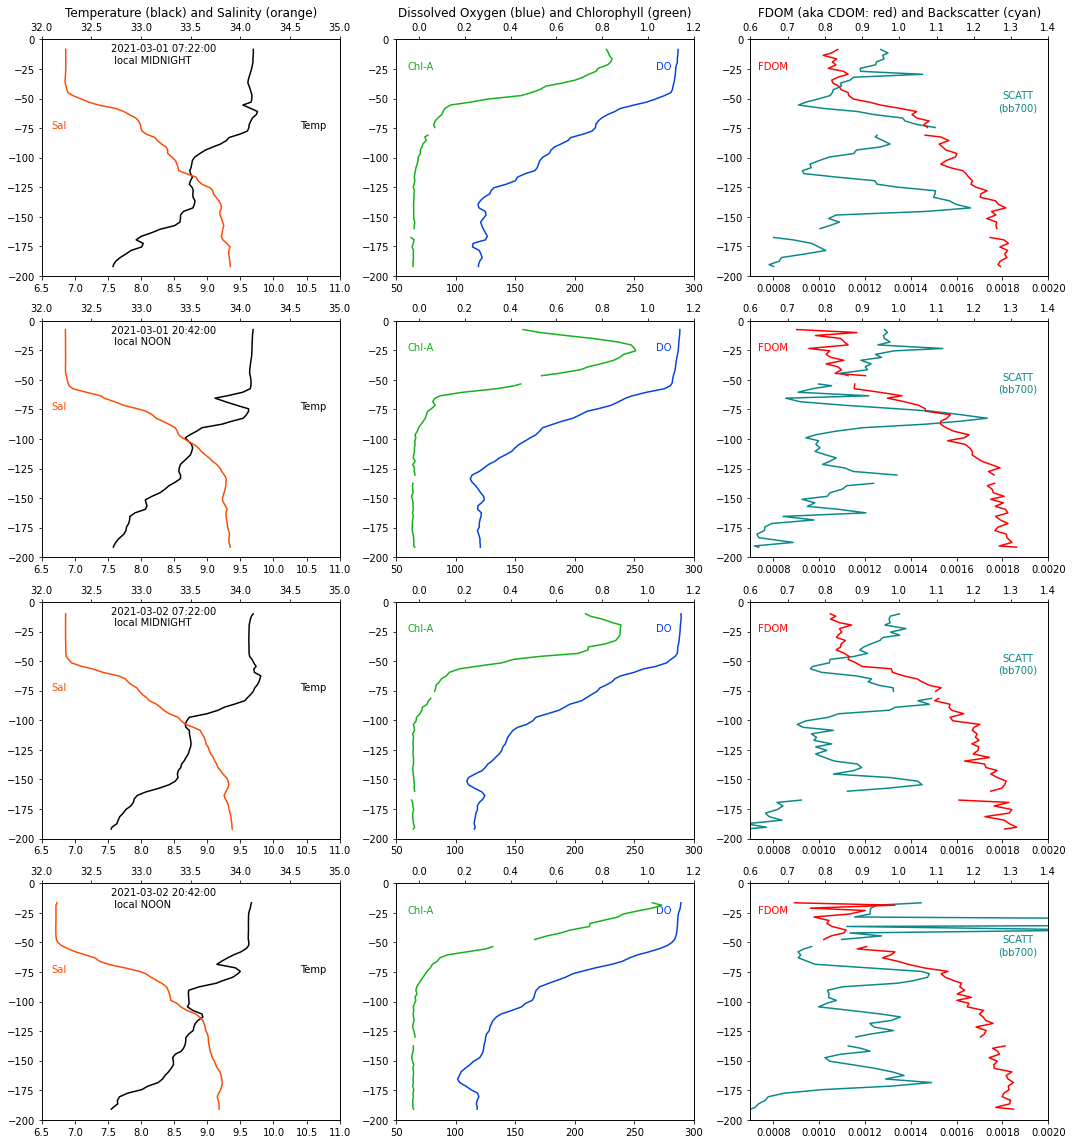

In [52]:
xrng=[(temp_lo, temp_hi), (salinity_lo, salinity_hi), (do_lo, do_hi), \
      (chlora_lo, chlora_hi), (backscatter_lo, backscatter_hi), (cdom_lo, cdom_hi)]

profile_indices = [506, 511, 515, 520] #, 524, 529, 533, 538, 542, 547, 551, 556, 560, 565, 569, 574, 578, 583, 587, 592] 

fig, axs = SixSignalChartSequence(pDf21, xrng, profile_indices)

## Above charts: Discussion

As noted above, this chart comparison sequence expands its ambitions by including
CDOM, backscatter, temperature
and salinity in addition to Chlorophyll-A and dissolved oxygen. As before these charts show 
data from shallow profiler ascents.

These charts show

- Backscatter data are highly variable with depth; are they reliable? 

In [53]:
fig.savefig(os.getcwd() + "/Images/charts/ABCOST_signals_vs_depth_and_time.png")
print("figure saved to Images/charts")

figure saved to Images/charts


## Additional datasets

To this point we have looked at three CTD-based sensor types and three fluorometer types. 
We now consider: 

```
G        pCO2              <Note: No pCO2 data available for RCA Oregon Slope Base in 2021>
H        pH
N        nitrate
I        spectral irradiance (7 channels within the Dataset)
P        PAR
U        Velocity Eastward
V        Velocity Northward
W        Velocity Upward
```


Attempting 11 charts



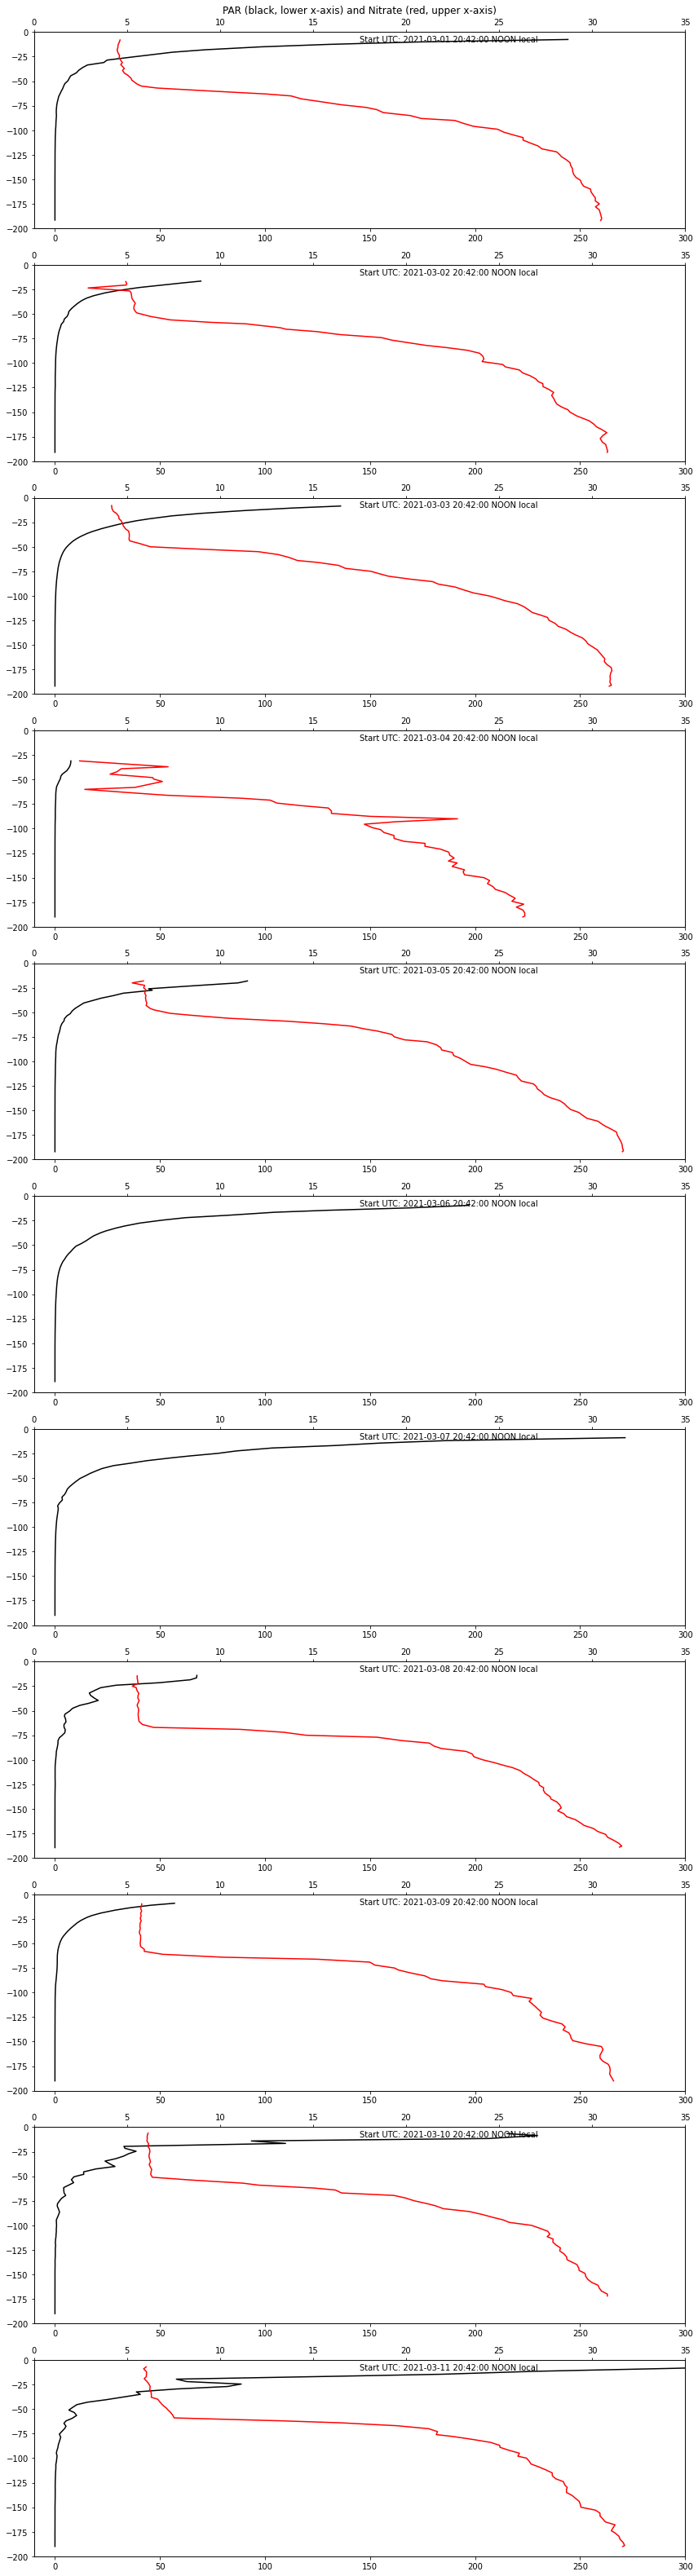

In [54]:
xrng = [(par_lo, par_hi), (nitrate_lo, nitrate_hi)]

# profile_indices = [506, 507, 508, 509, 510, 511, 512, 513, 514]
# profile_indices = [i for i in range(1200,1210)]

pIdcs = GenerateTimeWindowIndices(pDf21, dt64_from_doy(2021, 60), dt64_from_doy(2021, 70), noon0, noon1)
fig, axs = ChartAB(pDf21, xrng, pIdcs, dsP.par, dsP.z, 'PAR', 'black', dsN.nitrate, dsN.z, 'Nitrate', 'red')

In [55]:
# This cell can be used to glance at data availability for each type of data. It uses a 
#   very simple plot call to show presence/absence over the history of the cabled array
#   deployment. Both pCO2 and pH are 'no data' results; and upward velocity looks suspicious.
#   The other datasets look to be present during the first half of 2021.
#
# To recap the relevant part of the single-letter-designator table...
#
# Desig     Data                     Renamed                     Instrument
# -----     ----                     -------                     -----------
# G         pCO2                     pco2                        ?
# H         pH                       ph                          pH
# I         Spectral Irradiance      si412, si443, si490,        spkir
#                                    si510, si555, si620, si683   
# N         Nitrate                  nitrate                     nitrate
# P         PAR                      par                         PAR
# U         velocity east            veast                       ADCP?
# V         velocity north           vnorth                      ADCP?
# W         velocity up              vup                         ADCP?

# un-comment the next line and one of the sensor lines that follow
# fig, ax = plt.subplots(figsize=(12, 8), tight_layout=True)

# ax.plot(dsG.time, dsG.pco2,     ms = 1., color='blue', mfc='blue')    # no data
# ax.plot(dsH.time, dsH.ph,       ms = 1., color='blue', mfc='blue')    # no data
# ax.plot(dsI.time, dsI.si412,    ms = 1., color='blue', mfc='blue')    # good first half of 2021 (max 80)
# ax.plot(dsI.time, dsI.si443,    ms = 1., color='blue', mfc='blue')    # " 
# ax.plot(dsI.time, dsI.si490,    ms = 1., color='blue', mfc='blue')    # " 
# ax.plot(dsI.time, dsI.si510,    ms = 1., color='blue', mfc='blue')    # " 
# ax.plot(dsI.time, dsI.si555,    ms = 1., color='blue', mfc='blue')    # " 
# ax.plot(dsI.time, dsI.si620,    ms = 1., color='blue', mfc='blue')    # "  (max down around 15)
# ax.plot(dsI.time, dsI.si683,    ms = 1., color='blue', mfc='blue')    # "  (max down around 6)
# ax.plot(dsN.time, dsN.nitrate,  ms = 1., color='blue', mfc='blue')    # " 
# ax.plot(dsO.time, dsO.doxygen,  ms = 1., color='blue', mfc='blue')    # " 
# ax.plot(dsP.time, dsP.par,      ms = 1., color='blue', mfc='blue')    # "
# ax.plot(dsS.time, dsS.salinity, ms = 1., color='blue', mfc='blue')    # "
# ax.plot(dsT.time, dsT.temp,     ms = 1., color='blue', mfc='blue')    # "
# ax.plot(dsU.time, dsU.veast,    ms = 1., color='blue', mfc='blue')    # "
# ax.plot(dsV.time, dsV.vnorth,   ms = 1., color='blue', mfc='blue')    # "
# ax.plot(dsW.time, dsW.vup,      ms = 1., color='blue', mfc='blue')    # " suspiciously high amplitude in 2021


Attempting 6 charts



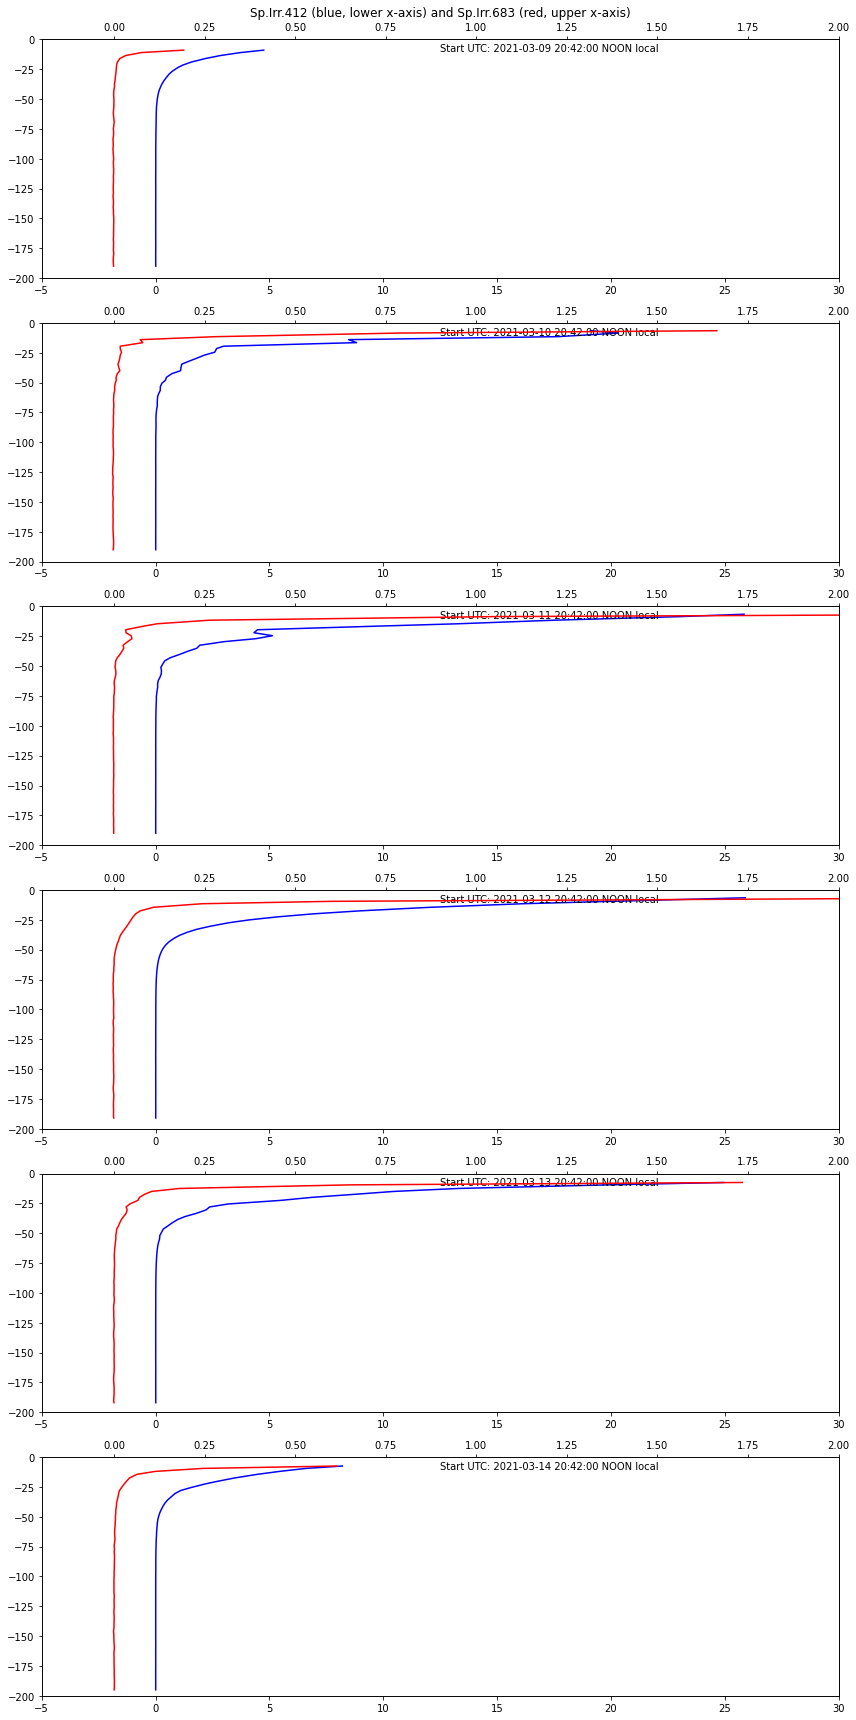

In [56]:
xrng = [(-5., 30.), (-.2, 2.)]
pIdcs = GenerateTimeWindowIndices(pDf21, dt64_from_doy(2021, 68), dt64_from_doy(2021, 73), noon0, noon1)
fig, axs = ChartAB(pDf21, xrng, pIdcs, dsI.si412, dsI.z, 'Sp.Irr.412', 'blue', \
                   dsI.si683, dsI.z, 'Sp.Irr.683', 'red')

### Current measurement

From [this web page](https://interactiveoceans.washington.edu/instruments/current-meter/): 

> The Shallow Profilers at Oregon Offshore, Slope Base, and the Axial Base sites use Nortek Vector VELPT instruments to measure the mean velocity (speed and direction) of water in two-dimensions (U & V) as it moves past the sensor, and as the profiler float moves through the water column.

A simple measurement of vertical shear: Take two locations from a single vertical profile and consider
only horizontal-plane velocities, respectively $\vec{a}$ and $\vec{b}$. If $\vec{a}$ and $\vec{b}$ are similar 
there is low shear. If they are diametric
there is higher shear. Most likely they will be distinct but not diametric. In this case we are free to
interpret the velocities as a mean current plus a diametric component. The latter will have 
a velocity magnitude given by $|\vec{a}-\vec{b}|$.


The following cell charts a couple of velocity profiles for two noon ascents: 
East component is green, north component is orange. 
Below that we review how the 'code machinery' in this notebook works before launching 
into the actual code to calculate ad hoc shear profiles. 

Attempting 3 charts



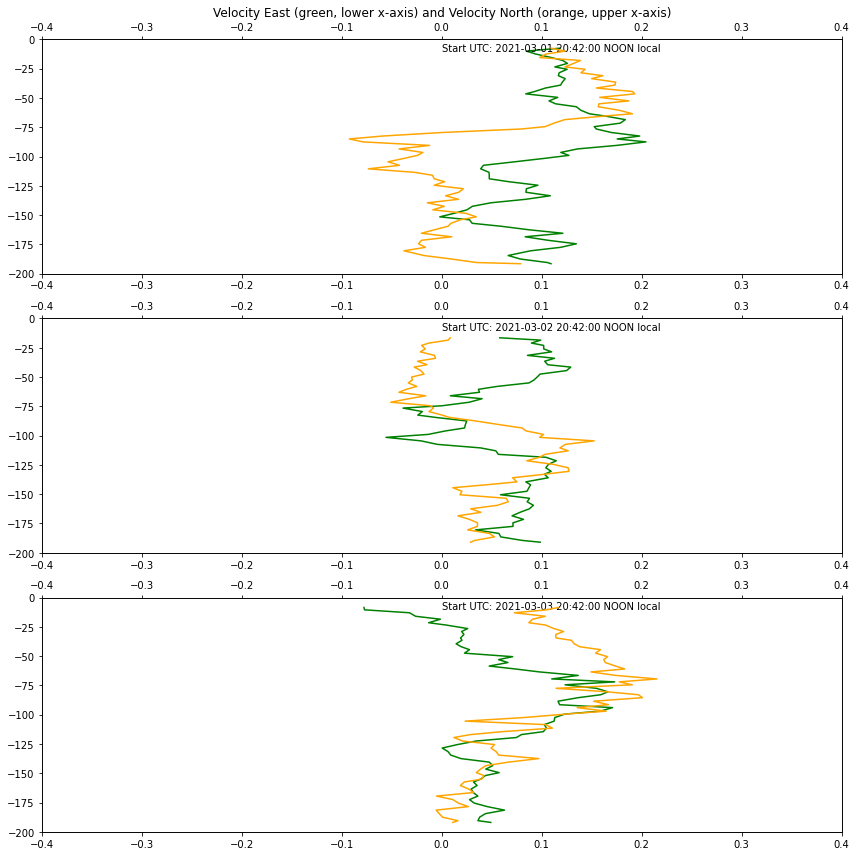

In [57]:
xrng = [(veast_lo, veast_hi), (vnorth_lo, vnorth_hi)]
pIdcs = GenerateTimeWindowIndices(pDf21, dt64_from_doy(2021, 60), dt64_from_doy(2021, 62), noon0, noon1)
fig, axs = ChartAB(pDf21, xrng, pIdcs, dsU.veast, dsU.z, 'Velocity East', 'green', \
                   dsV.vnorth, dsV.z, 'Velocity North', 'orange')

# Intermission: How this notebook code selects profile ascent data

* A separate set of notebooks (see Notebooks folder) produced tables of profile start/end times
    * Results are saved in the Profiles folder of this repository
    * Each saved CSV file is for a single year and a single location (from OSB, OOS, AXB)
        * Starting from 2015 and running through 2021 this results in 3 x 7 = 21 files
            * Owing to technical issues: Oregon Offshore is missing for 2021
        * Here we use strictly one of these: For OSB and 2021: **`osb2021.csv`**.
        
* **`ReadProfileMetadata(fnm)`** loads profile metadata into a (pandas) Dataframe **`pDf`**
    * Each row of **`pDf`**: dt64 times: start/end for all three of: ascent, descent, rest
    * We focus on **`ascent_start`** and **`ascent_end`**
    * The reference is hence pDf['ascent_start'][integer_index]
        * For OSB and 2021: integer_index = 0 will be the first (UTC) profile on January 1, 2021 at OSB
        * At nine profiles per day there are a maximum of 365 * 9 profiles in a year
        * We expect occasional drops and intervals of time when the profiler was not running
        
* **`GenerateTimeWindowIndices(pDf, date0, date1, time0, time1)`** produces a list of table row-indices for **`pDf`**
    * date0 and date1 define a range of days
    * time0 and time1 define a time range applied to each day
    * the list is extended for each **`ascent_start`** in **`pDf`** that falls within both
    
* Suppose we want to see only nitrate profiles, i.e. the noon and midnight profiles from each day
    * First generate a list using the midnight time range, say `list_midn`
    * Second generate a list using the noon time range, say `list_noon`
    * Combine the lists: These will be non-sequential indices for **`pDf`** rows
    * Use the list sorting method `list.sort()` to order this combined list. Result will be time-sequential.  
    
* Suppose we want sensor vs depth charts for a set of profiles
    * ...we have the corresponding list of profile indices (indexing into **`pDf`**) called **`pIdcs`**.
    * ...we have a Dataset of data from sensor **X** called **`dsX`**
    * Run an index **`i`** across **`pIdcs`**
        * For index **`i`** set a time range: **`t0, t1 = pDf['ascent_start'][pIdcs[i]], pDf['ascent_end'][pIdcs[i]]`**
        * Select data from the Dataset using this time range: **`Xs = dsX.sel(time=slice(t0, t1))`**
        
* To streamline comparison-charting for two sensors A and B we have the function **`ChartAB()`**
    * **`def ChartAB(pDf, xrng, pIdcs, A, Az, Albl, Acolor, B, Bz, Blbl, Bcolor)`**
        * **`pDf`** is the profile metadata described above
        * **`xrng`** is a list of low/high tuples for A and B
        * **`pIdcs`** is a list of profile indices. 
            * The length of this list corresonds to the number of charts to be produced
        * A and Az are data and z-value DataArrays, same for B and Bz
            * From a Dataset **`As`** these would be passed as **`As.sensorname`** and **`As.z`**


### High Priority Action List

- Fix the nitrate sequence to include midnight and noon both, sorted (see above)
- Modify the various charting functions (ABChart and Six-Sensor) to accept year and site
- Place in this section a brief description of element-wise calculation (see shear, below)
    - Include integrating shear as a new DataArray in a Dataset
- Streamline the multi-chart below: Fewer signals for the showcase animation; and see below
- Extract a source dataset that fits in the repo to make it more hermetic
    - The date ranges used in this notebook are...
- Filter velocity e.g. 30 meter box filter before calculating shear
- **Continuation items**
    - Regenerate the animation: 918 frames, datetime upper left; multiple versions incl. less clutter
    - Do a nitrate-specific animation 
    - Convert velocity components to directional vectors (and verify they are platform, not profiler-based)
    - Choose profiles for side-by-side comparison using widgets
    - Get some glider data from OOI
    - The 2021 / Jan profile analysis is hardcoded (and re-hardcoded below for 2018)...

[511, 520]



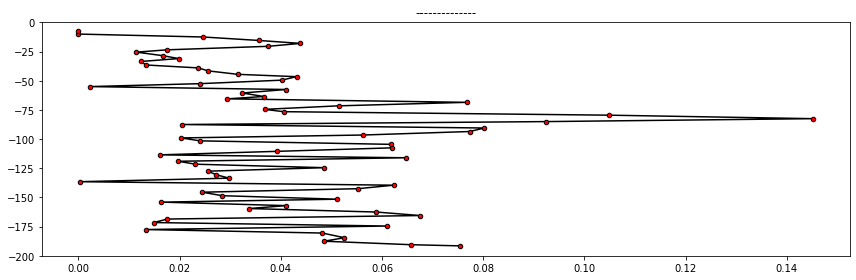

In [58]:
# get a list of ascent indices (for dataframe pDf21, OSB 2021) for March 1, 2021
t_midnight = td64(0, 'm')
t_almost_midnight = td64(24*60-1, 'm')
list_of_ascents = GenerateTimeWindowIndices(pDf21, dt64('2021-03-01'), dt64('2021-03-02'), noon0, noon1)
print(list_of_ascents)

def ShearProfile(v, offset):
    """Calculate shear from a Dataset dim=time, data vars = veast, vnorth, z"""
    # verify the time dimension
    if not v.dims['time']: return v
    len_v = v.dims['time']
    return [0. if i + offset >= len_v else                               \
         np.sqrt((vel['veast'][i]-vel['veast'][i + offset])**2 +         \
                 (vel['vnorth'][i]-vel['vnorth'][i + offset])**2)        \
         for i in range(len_v)]

i=0
offset=2
veast  = dsU.sel(time=slice(pDf21['ascent_start'][list_of_ascents[i]], pDf21['ascent_end'][list_of_ascents[i]]))
vnorth = dsV.sel(time=slice(pDf21['ascent_start'][list_of_ascents[i]], pDf21['ascent_end'][list_of_ascents[i]]))
vel    = xr.merge([veast, vnorth])
shear = ShearProfile(vel, offset)

fig, axs = plt.subplots(figsize=(12,4), tight_layout=True)
axs.plot(shear, vel.z, marker='.', ms=9., color='k', mfc='r')
axs.set(ylim = (-200., 0.), title='--------------'); print()

In [32]:
np.sqrt((vel['veast'][0] - vel['veast'][2])**2 + (vel['vnorth'][0] - vel['vnorth'][2])**2)

<xarray.DataArray ()>
array(0.07550442)

In [33]:
vel

<xarray.Dataset>
Dimensions:  (time: 67)
Coordinates:
  * time     (time) datetime64[ns] 2021-03-01T20:42:00 ... 2021-03-01T21:48:00
Data variables:
    veast    (time) float64 ...
    z        (time) float64 -191.5 -190.5 -187.5 -184.5 ... -12.5 -10.0 -7.5
    vnorth   (time) float64 ...
Attributes: (12/44)
    cdm_altitude_proxy:            z
    cdm_data_type:                 TimeSeriesProfile
    cdm_profile_variables:         time
    cdm_timeseries_variables:      station,longitude,latitude
    contributor_email:             feedback@axiomdatascience.com
    contributor_name:              Axiom Data Science
    ...                            ...
    standard_name_vocabulary:      CF Standard Name Table v72
    station_id:                    104293
    summary:                       Timeseries data from 'Regional Cabled Arra...
    time_coverage_end:             2021-08-02T23:59:00Z
    time_coverage_start:           2014-10-06T23:32:00Z
    title:                         Regional Cabled Array: Oregon Slope Base S...

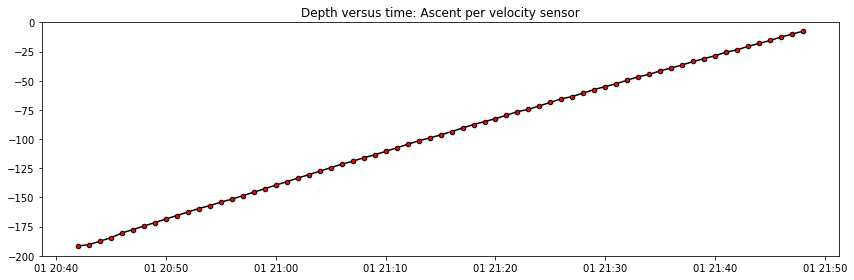

In [34]:
fig, axs = plt.subplots(figsize=(12,4), tight_layout=True)
axs.plot(vel.time, vel.z, marker='.', ms=9., color='k', mfc='r')
axs.set(ylim = (-200., 0.), title='Depth versus time: Ascent per velocity sensor'); print()

In [35]:
vel.var

<bound method ImplementsDatasetReduce._reduce_method.<locals>.wrapped_func of <xarray.Dataset>
Dimensions:  (time: 67)
Coordinates:
  * time     (time) datetime64[ns] 2021-03-01T20:42:00 ... 2021-03-01T21:48:00
Data variables:
    veast    (time) float64 0.1093 0.1057 0.07867 ... 0.09405 0.08465 0.1181
    z        (time) float64 -191.5 -190.5 -187.5 -184.5 ... -12.5 -10.0 -7.5
    vnorth   (time) float64 0.07884 0.0349 0.009809 ... 0.1042 0.1235 0.1095
Attributes: (12/44)
    cdm_altitude_proxy:            z
    cdm_data_type:                 TimeSeriesProfile
    cdm_profile_variables:         time
    cdm_timeseries_variables:      station,longitude,latitude
    contributor_email:             feedback@axiomdatascience.com
    contributor_name:              Axiom Data Science
    ...                            ...
    standard_name_vocabulary:      CF Standard Name Table v72
    station_id:                    104293
    summary:                       Timeseries data from 'Regional Ca

In [36]:
# Chooser skeleton code from nbk Ocean 01 F Profiler Visualization
# ----------------------------------------------------------------
#


## Alfresco server discrete data


Our objective in this section is to interpret **Discrete Summary** data files for the Regional Cabled Array 
cruises, particularly for 2016 to present. This requires some explanation (what is meant by "**Discrete Summary**"?)
because we have two types of cast data: From discrete water samples and from continuously operating sensors.
The first idea here is to stay with the discrete water samples. These are grabbed at distinct times and depths.
Since the sampler also carries sensors that run continuously, the idea is to isolate short snippets of that
*continous* data that correspond to the times of the discrete sample captures. In this way the continuous sensors
are incorporated into the discrete analysis.


* Cruise data are available from the OOI 'Alfresco' server
    * [Alfresco browse site](https://alfresco.oceanobservatories.org/alfresco/faces/jsp/browse/browse.jsp)
    * Navigate: Cabled array > Cruise data > (year of choice) > Ship Data > Water Sampling
    * Example: (year of choice) = 2021 is folder **Cabled-12_TN393_2021-07-30**
        * TN refers to the ship: Thompson. Atlantis = AT; Revelle = RR; Sikuliaq = SKQ (2016 cruise)
        * 393 refers to the cruise number
            * Cabled-12 indicates the OOI Regional Cabled Array; where 12 is simply an index number (by year)
            * For the OOI cabled array the annual cruise uses Newport OR as the base of operations
            * The cruise consists of a series of sorties or 'legs', each typically 5-10 days
            * The provided date 2021-07-30 indicates the year and approximate date of the cruise start
    * In the Water Sampling folder there are two files of interest
        * **Cabled-12_TN393_Discrete_Summary-README.pdf** is a guide to deciphering the data, particularly ephemeris flags
        * **Cabled-12_TN393_Discrete_Summary.csv** is a tabular data file 
            * This file is the **Discrete Summary** of interest
            * It summarizes cast sample data and synchronous continuous sensor data; see below

* **Discrete Summary** data are associated with Niskin bottle trigger events
    * A Niskin bottle is deployed in 'open' state on a submerged framework
        * Most commonly this framework is a [rosette](https://www.whoi.edu/what-we-do/explore/instruments/instruments-sensors-samplers/rosette-sampler/)
        * A Remotely Operated Vehicle (ROV) can also be used as a Niskin bottle framework
        * For our purposes here we just use the term 'rosette' to refer to the sample bottle framework
    * Submerged rosettes capture water samples in Niskin bottles
        * Rosettes also carry sensors that continuously record data, typically at one sample per second
            * Examples of continuous sensor data includes seawater conductivity, temperature, depth, and fluorescence
    * Niskin bottles are lengths of pipe with two end caps
        * They are deployed in an open state so seawater flows through them
        * When they are triggered: Caps under tension are released so as to seal the ends of the pipe
        * As a results a seawater sample from some depth is captured for later (shipboard laboratory) analysis
   
* Continuous data
    * Rosette downcast (from shipboard down through the water column) is optimal for continuous sensors
        * The water is relatively undisturbed as the rosette is lowered
    * Rosette upcast is when Niskin bottles are typically triggered
        * On ascent: The Rosette is left at a trigger depth for 30 - 60 seconds before the actual trigger
            * This allows the sensors to stabilize / equilibrate
    * The continuous data is available under file extension **`.hex`** plus supporting **`.xmlcon`** files
        * These can be analyzed using (freely available) software from SeaBird: search 'seabird ctd software'
    * The Niskin bottle firing times are timestamped
        * The corresponding continuous data can be extracted, i.e. corresponding to the bottle firing times
        * This extracted continuous data is stored in 'bottle' files, extension **`.btl`**
    * A typical cast might take an hour; producing 3600 sensor values from a continuous sensor
        * That cast might include 24 Niskin bottle captures. 
        * Hence only '24' of the 3600 continuous sensor data values pertain to the **Discrete Summary**
            * The continuous profile (from the downcast) is dealt with separately.
                * Minor point: Some continuous sensors make use of 'plumbing' with intrinsic inter-sensor delays
                * Small time corrections ('alignments') are applied
    * Discrete sampling is used as a 'gold standard' to inform subsequent continuous profile data cleaning
    
    
### Additional details


* Clarify: Nitrate versus nitrite
* Clarify: Discrete versus Calculated pCO2 
* The repo folder **`DiscreteSummaries`** contains:
    * Tabular data (**`.csv`**) for 2015 - 2021
    * README metadata (**`.pdf`**) for 2015 - 2021
    * Renamed for simplicity: **`RCA2021_TN_DiscSumm.csv`** and **`README_RCA2021.pdf`** etcetera


### Statement of the analytical problem


The high-level objective is to reach scientific insight from the OOI observational data. The 
corresponding fundamental question concerning shallow profiler data is 'How stable and reliable 
are the data from a given profile?' To approach this question we would like independent observations.
This is the value of the cruise water sample data and the associated continuous data from the 
rosette casts. To make progress here we have a series of comparatives: First comparing discrete
data from one cast to another, then secondly comparing discrete data upcasts with continuous data downcasts.
Thirdly we can compare upcast and downcast data with shallow profiler data. For brevity we adopt 
these terms:

* Upcast comparisons (discrete data between two rosette upcasts)
* Discrete-continuous comparisons (upcast versus downcast data)
* Rosette-Profiler comparisons 

For thoroughness we should look through all data from 2016 through 2021; but 2018 is of particular
interest as it included a relatively large number of casts. 

## Upcast distances


Two distinct rosette upcasts have both spatial and time separation.
This suggests coherence times and distances: How far (spatial / time) to move before cast data are uncorrelated? 

We have three shallow profiler sites (abbreviated OOS, OSB and AXB) and seven years of data: 2015 -- 2021.
The easiest place to start is to look at the cast summaries for each year to identify comparable casts.


**`SP`** is Shallow Profiler station. Cast location is stated relative; but the cast might go much deeper than 200 meters.
**`DP`** is Deep Profiler station
**`CTD-002`** is a CTD cast with index (skips are common)
**`500m W`** indicates an offset from the station position
** Needed: Station differences for Deep and Shallow profilers at each site


### 2015

```
1.
```

### 2016

```
1.
```

### 2017

```
1.
```

### 2018


```
1. OSB SP, CTD-002, 2018-06-26T20:23:04.000Z, 500m W
2. AXB SP, CTD-003, 2018-07-02T20:59:24.000Z, 500m E
3. OSB SP, CTD-006, 2018-07-10T20:45:57.000Z, 250m W 
4. OSB SP, CTD-008, 2018-07-10T22:43:40.000Z, 500m W
5. OOS SP, CTD-009, 2018-07-15T04:39:48.000Z,   0m 
6. OOS SP, CTD-011, 2018-07-17T22:38:58.000Z, 250m E
7. OOS DP, CTD-013, 2018-07-23T23:20:04.000Z, 500m SW
8. OSB DP, CTD-014, 2018-07-25T17:47:23.000Z, 750m E
9. AXB SP, CTD-016, 2018-07-27T06:21:49.000Z, 500m E
```


Comparatives: 


* **`OSB 1 vs 3 vs 4 (vs 8, DP):    ['CTD-002', 'CTD-006', 'CTD-008', 'CTD-014']`**
* **`AXB we have 2 vs 9             ['CTD-003', 'CTD-016']`**
* **`OOS we have 5 vs 6 (vs 7, DP)  ['CTD-009', 'CTD-011', 'CTD-013']`**


### 2019


```
1. OOS SP, CTD-005, 2019-06-13T21:38:14.000Z,  250m W
2. OSB SP, CTD-006, 2019-06-14T11:24:21.000Z,  250m W
3. AXB DP, CTD-007, 2019-06-17T22:27:51.000Z, 1000m E (SP: 550m E)
4. OOS SP, CTD-008, 2019-06-24T05:30:10.000Z,  250m W
5. OSB SP, CTD-010, 2019-06-27T19:38:18.000Z,  250m W
6. OOS SP, CTD-012, 2019-06-28T17:31:26.000Z,  250m W
7. AXB DP, CTD-013, 2019-07-07T06:22:44.000Z, 1000m E (SP: 550m E)
8. AXB DP, CTD-014, 2019-07-07T08:17:00.000Z, 1000m E (SP: 550m E)
```


Comparatives: 


* OSB we have 2 vs 5
* AXB we have 3 vs 7 vs 8
* OOS we have 1 vs 4 vs 6



### 2020


```
1. OSB SP, CTD-001, 2020-08-03T15:17:41.000Z,    0m
2. AXB DP, CTD-003, 2020-08-08T21:53:32.000Z, 1000m E
3. AXB DP, CTD-004, 2020-08-08T23:36:18.000Z, 1000m E
4. OSB SP, CTD-006, 2020-08-11T04:28:22.000Z, 1300m NE
5. OSB SP, CTD-007, 2020-08-11T05:48:08.000Z, 1300m NE
6. OOS SP, CTD-009, 2020-08-11T23:39:18.000Z,  500m W
7. OOS SP, CTD-010, 2020-08-12T00:49:20.000Z,  500m W
```


Comparatives: 


* OSB we have 1 vs 4 vs 5
* AXB we have 2 vs 3
* OOS we have 6 vs 7


### 2021


```
1. AXB SP, CTD-001, 2021-08-03T01:25:44.000Z, 500m NW
2. AXB SP, CTD-003, 2021-08-04T13:48:19.000Z, 500m E
3. OSB SP, CTD-005, 2021-08-06T01:43:57.000Z, 500m SW
4. OOS SP, CTD-006, 2021-08-26T09:16:44.000Z, 500m E
5. AXB DP, CTD-007, 2021-09-01T05:03:07.000Z, 1000m E
```


Comparatives:


* AXB we have 1 versus 2 versus 5

The **numpy** library has a **datetime64** type used in this notebook. Pandas has a related type called **datetime**. 
There is also a common need to sort out time differences, for example using **timestamps**. For an explanation of 
Python constructs such as **`datetime`**, **`datetime64`** and **`timestamp`**: Search for a good web
resource such as
[this one](https://www.kite.com/python/answers/how-to-convert-between-datetime,-timestamp,-and-datetime64-in-python).


The following cell reads in discrete summary data (CSV files pulled from the OOI alfresco server) for use in 
intercomparison of CTD casts and comparison of those casts with shallow profiler data. 

In [37]:
def ReadDiscreteSummary(fnm):
    """
    Discrete summary files bring together three data sources: Niskin bottle sample analysis data (with 
    discrete sample times), calculated (post-processed) data values, and continuous sensor data subsets
    (from times that correspond to Niskin bottle captures). The discrete summary is a CSV file with rows
    corresponding to Niskin bottle samples and columns corresponding to these three data types. The
    CSV file typically has many NaN values (-9999999). The file is loaded into a DataFrame which selects
    out a large subset of the full complement of columns. These selected columns are subsequently
    renamed to make the data a little simpler to code against. 'CTD Temperature 1 [deg C]' becomes 'temp1'
    for example. Time values are then converted to datetime64 (herein abbreviated dt64). This applies 
    to both cast start time -- typically when the rosette entered the water -- and the Niskin closure times.
    """
    
    # Read the Discrete Summary CSV into a Dataframe dsDf
    dsDf = pd.read_csv(fnm, usecols=["Station", "Start Latitude [degrees]", "Start Longitude [degrees]",            \
                                   "Start Time [UTC]", "Cast", "Cast Flag", "Bottom Depth at Start Position [m]", \
                                   "CTD File Flag", "Niskin/Bottle Position", "Niskin Flag",                      \
                                   "CTD Bottle Closure Time [UTC]",                                               \
                                   "CTD Pressure [db]",                                                           \
                                   "CTD Depth [m]", "CTD Latitude [deg]", "CTD Longitude [deg]",                  \
                                   "CTD Temperature 1 [deg C]",                                                   \
                                   "CTD Temperature 2 [deg C]",                                                   \
                                   "CTD Salinity 1 [psu]",                                                        \
                                   "CTD Salinity 2 [psu]",                                                        \
                                   "CTD Oxygen [mL/L]",                                                           \
                                   "CTD Oxygen Saturation [mL/L]",                                                \
                                   "CTD Fluorescence [mg/m^3]",                                                   \
                                   "CTD Beam Attenuation [1/m]",                                                  \
                                   "CTD Beam Transmission [%]",                                                   \
                                   "CTD pH",                                                                      \
                                   "Discrete Oxygen [mL/L]",                                                      \
                                   "Discrete Chlorophyll [ug/L]",                                                 \
                                   "Discrete Phaeopigment [ug/L]",                                                \
                                   "Discrete Fo/Fa Ratio",                                                        \
                                   "Discrete Phosphate [uM]",                                                     \
                                   "Discrete Silicate [uM]",                                                      \
                                   "Discrete Nitrate [uM]",                                                       \
                                   "Discrete Nitrite [uM]",                                                       \
                                   "Discrete Ammonium [uM]",                                                      \
                                   "Discrete Salinity [psu]",                                                     \
                                   "Discrete DIC [umol/kg]",                                                      \
                                   "Discrete pH [Total scale]",                                                   \
                                   "Calculated DIC [umol/kg]",                                                    \
                                   "Calculated pCO2 [uatm]",                                                      \
                                   "Calculated pH",                                                               \
                                   "Calculated CO2aq [umol/kg]",                                                  \
                                   "Calculated Bicarb [umol/kg]",                                                 \
                                   "Calculated CO3 [umol/kg]",                                                    \
                                   "Calculated Omega-C",                                                          \
                                   "Calculated Omega-A"                                                           \
                                  ])
    
    dsDf.columns=['station', 'lat', 'lon', 'cast start', 'cast', 'cast flag', 'bottom depth',    \
                'ctd flag', 'niskin', 'niskin flag', 'closure time', 'ctd pressure',           \
                'ctd depth', 'ctd lat', 'ctd lon', 'temp1', 'temp2', 'sal1', 'sal2',           \
                'oxygen', 'saturation', 'fluorescence', 'attenuation', 'transmission',         \
                'pH', 'discrete oxygen', 'discrete chlorophyll', 'discrete phaeopigment',      \
                'discrete Fo/Fa', 'discrete phosphate', 'discrete silicate',                   \
                'discrete nitrate', 'discrete nitrite', 'discrete ammonium',                   \
                'discrete salinity', 'discrete DIC', 'discrete pH',                            \
                'calculated DIC', 'calculated pCO2', 'calculated pH', 'calculated CO2aq',      \
                'calculated bicarb', 'calculated CO3', 'calculated Omega-C',                   \
                'calculated Omega-A'
               ]

    dsDf['cast start']   = pd.to_datetime(dsDf['cast start'], errors='ignore')
    dsDf['closure time'] = pd.to_datetime(dsDf['closure time'], errors='ignore')

    # return: Using df.T will transpose the DataFrame: index becomes the above attributes and columns are samples
    return dsDf    

dsDf = ReadDiscreteSummary(os.getcwd()+"/./DiscreteSummaries/RCA2018_RR_DiscSumm.csv")

In [38]:
def CastSubset(dsDf, cast, columns):
    '''
    dsDf is a Discrete Summary Dataframe
    cast is a string corresponding to the cast identifier, e.g. 'CTD-001'
    columns is a list of column names to extract from the full Dataframe
    Returns a Dataframe for 'just that cast' and 'just those parameters'
    '''
    return dsDf.loc[(dsDf['cast']==cast)][columns]

# OSB 2018 (see comparatives above)
cast_list = ['CTD-002', 'CTD-006', 'CTD-008', 'CTD-014']
a = [CastSubset(dsDf, c, ['closure time', 'temp1', 'temp2', 'ctd depth']) for c in cast_list]

print(a[0]['closure time'].iloc[0], '---', a[1]['closure time'].iloc[0], '---',\
      a[2]['closure time'].iloc[0], '---', a[3]['closure time'].iloc[0])

# notes: how to get into human-readable time gaps:
# 1 + int((theDatetime - dt64(str(theDatetime)[0:4] + '-01-01')) / td64(1, 'D'))

2018-06-26T20:42:14.000Z --- 2018-07-10T20:53:45.000Z --- 2018-07-10T23:40:58.000Z --- 2018-07-25T18:47:22.000Z


In [39]:
def GetProfileDataFrameIndicesForSomeTime(site, year, target, window):
    '''
    This is a convenience function that bundles the profile metadata read with the scan for
    profiles that match both a date window and a time-of-day window. The 'site' and 'year' 
    arguments are strings. The target is a target datetime; so we want the shallow profiler
    profile index that mostly closely matches it. 'window' is a +- window in minutes. This 
    code has two major flaws at the moment.
      - It will not work across day boundaries
      - It returns a list of suitable indices; so these must be sorted out by inspection
    '''
    pDf             = ReadProfileMetadata(os.getcwd() + "/./Profiles/" + site + year + ".csv")        
    t_date          = dt64(target.split('T')[0])                                        
    t_time          = target.split('T')[1].split(':')                                
    t_hrs, t_min    = int(t_time[0]), int(t_time[1])     
    t_early, t_late = td64(t_hrs*60 + t_min - window, 'm'), td64(t_hrs*60 + t_min + window, 'm')    
    return GenerateTimeWindowIndices(pDf, t_date, t_date, t_early, t_late), pDf

pIdcs_CTD002, pDf18 = GetProfileDataFrameIndicesForSomeTime('osb', '2018', a[0]['closure time'].iloc[0], 60)
pIdcs_CTD006, pDf18 = GetProfileDataFrameIndicesForSomeTime('osb', '2018', a[1]['closure time'].iloc[0], 60)

# For CTD-002 the comparative profiler Dataframe index is 617; for CTD-006 it is 640

for idx in pIdcs_CTD002: print(pDf18['ascent_start'][idx], '  ~~compare to cast~~>  ', a[0]['closure time'].iloc[0])
for idx in pIdcs_CTD006: print(pDf18['ascent_start'][idx], '  ~~compare to cast~~>  ', a[1]['closure time'].iloc[0])

Ts0 = dsT.sel(time=slice(pDf18['ascent_start'][pIdcs_CTD002[0]], pDf18['ascent_end'][pIdcs_CTD002[0]]))
Ts1 = dsT.sel(time=slice(pDf18['ascent_start'][pIdcs_CTD006[0]], pDf18['ascent_end'][pIdcs_CTD006[0]]))

2018-06-26 20:42:00   ~~compare to cast~~>   2018-06-26T20:42:14.000Z
2018-07-10 20:42:00   ~~compare to cast~~>   2018-07-10T20:53:45.000Z


In [40]:
pDf18['ascent_start'][617]

Timestamp('2018-06-26 20:42:00')

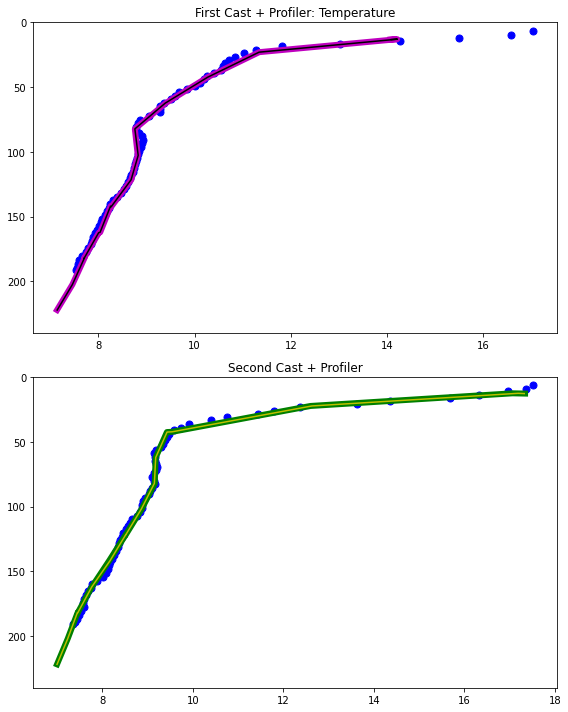

In [41]:
# compare the two shallow casts a[0] and a[1]
fig, axs = plt.subplots(2, 1, figsize=(8, 10), tight_layout=True)
axs[0].plot(a[0]['temp1'], a[0]['ctd depth'], linewidth=6, color='m')
axs[0].plot(a[0]['temp2'], a[0]['ctd depth'], color='k')
axs[1].plot(a[1]['temp1'], a[1]['ctd depth'], linewidth=6, color='g')
axs[1].plot(a[1]['temp2'], a[1]['ctd depth'], color='y')
axs[0].scatter(Ts0.temp, -Ts0.z, color='b', s=49.)
axs[1].scatter(Ts1.temp, -Ts1.z, color='b', s=49.)
axs[0].set(ylim = (240., 0.), title='First Cast + Profiler: Temperature'); 
axs[1].set(ylim = (240., 0.), title='Second Cast + Profiler'); 
print()

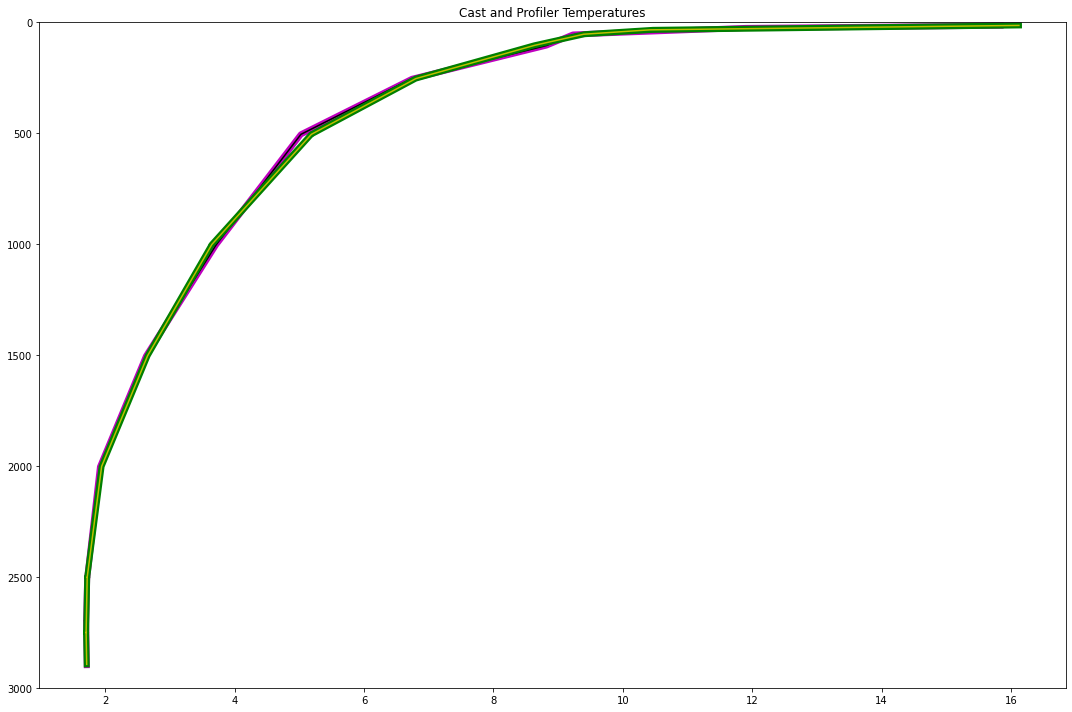

In [42]:
# compare the two shallow casts a[0] and a[1]
fig, axs = plt.subplots(figsize=(15, 10), tight_layout=True)
axs.plot(a[2]['temp1'], a[2]['ctd depth'], linewidth=6, color='m')
axs.plot(a[2]['temp2'], a[2]['ctd depth'], color='k')
axs.plot(a[3]['temp1'], a[3]['ctd depth'], linewidth=6, color='g')
axs.plot(a[3]['temp2'], a[3]['ctd depth'], color='y')
axs.set(ylim = (3000., 0.), title='Cast and Profiler Temperatures'); 
print()

In [43]:
# This cell gives us an idea (for a given month) how much of the time the shallow profiler was working

year = '2018'
month = '06'
next_month = '07'
t0, t1 = dt64(year + '-' + month + '-01'), dt64(year + '-' + next_month + '-01')
nDays = (t1 - t0).astype(int)
nTotal, nMidn, nNoon = ProfileEvaluation(t0, t1, pDf18)

print("For " + year + " and month " + month + ': There are ')
print(nDays, 'days or', nDays*9, 'possible profiles')
print("There were, over this time, en fait:")
print(nTotal, 'profiles;', nMidn, 'at local midnight and', nNoon, 'at local noon')
print()


For 2018 and month 06: There are 
30 days or 270 possible profiles
There were, over this time, en fait:
35 profiles; 3 at local midnight and 5 at local noon



## Animated time series profiles

This section concerns creating animations of profile charts. 

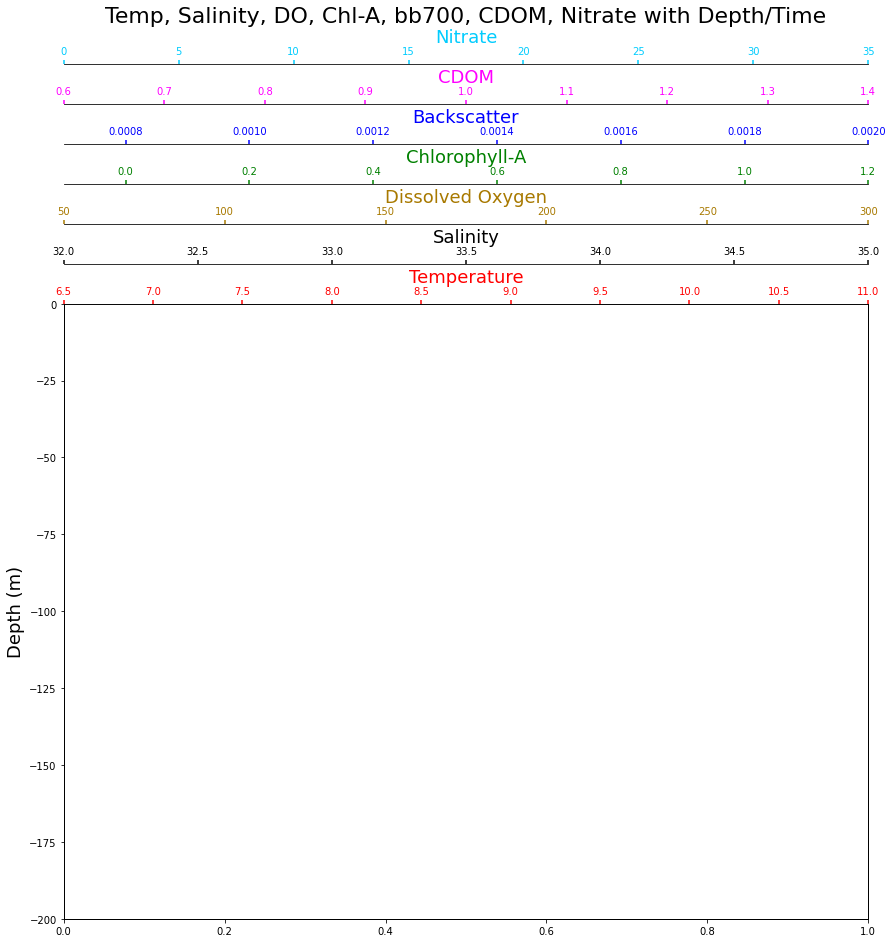

In [71]:
# Animated time series

from matplotlib import animation, rc
from IPython.display import HTML, Video

site = 'osb'
year = '2021'
pDf21 = ReadProfileMetadata(os.getcwd() + "/./Profiles/" + site + year + ".csv")        
nframes = 250

fig, axs = plt.subplots(figsize=(12.5,14), tight_layout=True)

# configuration lists with seven elements each, one for each sensor
clr = ['red', 'black', 'xkcd:bronze', 'green', 'blue', 'magenta', 'xkcd:bright sky blue']
lows = [temp_lo, salinity_lo, do_lo, chlora_lo, backscatter_lo, cdom_lo, nitrate_lo]
highs = [temp_hi, salinity_hi, do_hi, chlora_hi, backscatter_hi, cdom_hi, nitrate_hi]
lbls = ["Temperature","Salinity","Dissolved Oxygen","Chlorophyll-A","Backscatter","CDOM","Nitrate"]
offs = [1.0, 1.065, 1.130, 1.195, 1.260, 1.325, 1.390]
mrkrs = ['o', 's', 'D', 'p', 'v', 'h', 'h']

axs.set_title('Temp, Salinity, DO, Chl-A, bb700, CDOM, Nitrate with Depth/Time')
axs.title.set_fontsize(22)
axs.yaxis.label.set_color('k')
axs.yaxis.label.set_fontsize(18)
axs.set_ylabel("Depth (m)")

axs.xaxis.label.set_fontsize(18)

atw = [axs.twiny() for i in range(7)]            # twin y-axes supporting the 7 sensor types

# Configures all of the twin axes per the above configuration lists
for i in range(7): 
    atw[i].set(xlim = (lows[i], highs[i]), ylim = (-200., 0.))
    atw[i].xaxis.label.set_fontsize(18)
    atw[i].set_xlabel(lbls[i])
    atw[i].xaxis.set_ticks_position('top')
    atw[i].spines['top'].set_position(('axes', offs[i]))
    atw[i].xaxis.label.set_color(clr[i])
    atw[i].tick_params(axis='x', colors=clr[i], size=4, width=1.5)

lines = [atw[i].plot([], [], lw=1, marker=mrkrs[i], ms = 6., c=clr[i], mfc=clr[i])[0] for i in range(7)]

def AnimateInit():
    for i in range(7): lines[i].set_data([], [])
    return lines

pIdcs = [i for i in range(506, 506+nframes)]

def AnimateChart(frame):

    global pIdcs
    
    t0, t1 = pDf21['ascent_start'][pIdcs[frame]], pDf21['ascent_end'][pIdcs[frame]]

    Ts = dsT.sel(time=slice(t0, t1))
    Ss = dsS.sel(time=slice(t0, t1))
    Os = dsO.sel(time=slice(t0, t1))
    As = dsA.sel(time=slice(t0, t1))
    Bs = dsB.sel(time=slice(t0, t1))
    Cs = dsC.sel(time=slice(t0, t1))
    Ns = dsN.sel(time=slice(t0, t1))

    lines[0].set_data(Ts.temp, Ts.z)
    lines[1].set_data(Ss.salinity, Ss.z)
    lines[2].set_data(Os.doxygen, Os.z)
    lines[3].set_data(As.chlora, As.z)
    lines[4].set_data(Bs.backscatter, Bs.z)
    lines[5].set_data(Cs.cdom, Cs.z)
    lines[6].set_data(Ns.nitrate, Ns.z)
    
    clear_output(wait = True)
    print("animating frame", frame) 
    return lines


# This code creates the animation; requires some time so it is commented out for now.
# anim = animation.FuncAnimation(fig, AnimateChart, init_func=AnimateInit, \
#                                frames=nframes, interval=250, blit=True, repeat=False)
#
# Use 'HTML(anim.to_html5_video())'' for direct playback
# anim.save(this_dir + '/Images/animations/multisensor_animation.mp4')

## Binder-friendly playback


The cell above creates an animation file that is stored within this repository. 
The cell below plays it back (for example in **binder**) to show multiple profile animations.
Nitrate is intermittent, appearing as a sky-blue line in 2 of every 9
frames. The remaining sensors are present in each frame.


There animation begins March 1 2021 and proceeds at a rate of nine frames (profiles) per day.
Change playback speed using the video settings control at lower right.

In [72]:
# Binder-friendly playback
from IPython.display import HTML, Video
import os
Video(os.getcwd() + '/Images/animations/multisensor_animation.mp4', embed=True)